###  Imports and Setup:

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import alexnet, resnet18, mobilenet_v2
from torch.utils.data import random_split
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### Helper Functions

In [ ]:
def train_step(model, dataloader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def eval_step(model, dataloader, criterion, device):

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def plot_metrics(train_losses, train_accs, val_losses, val_accs):

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_confusion_matrix(model, test_loader, device):

    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Loading

In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load full training set
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

# Split into train and validation (80-20 split)
val_size = int(0.1 * len(full_trainset))
train_size = len(full_trainset) - val_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                         shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64,
                                       shuffle=False, num_workers=2)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                        shuffle=False, num_workers=2)

print(f"Train set size: {len(trainset)}")
print(f"Validation set size: {len(valset)}")
print(f"Test set size: {len(testset)}")

Files already downloaded and verified
Files already downloaded and verified
Train set size: 45000
Validation set size: 5000
Test set size: 10000


### AlexNet

In [ ]:
# Initialize AlexNet
model = alexnet(pretrained=False)
model.classifier[-1] = nn.Linear(4096, 10)  # Modify for CIFAR-10
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 50
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc = eval_step(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print('-' * 60)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()

Epoch 1/50:
------------------------------------------------------------
Train Loss: 2.3025, Train Acc: 10.57%
Val Loss: 2.3021, Val Acc: 13.78%

Epoch 2/50:
------------------------------------------------------------
Train Loss: 2.3012, Train Acc: 11.83%
Val Loss: 2.2994, Val Acc: 11.14%

Epoch 3/50:
------------------------------------------------------------
Train Loss: 2.2560, Train Acc: 14.56%
Val Loss: 2.0765, Val Acc: 24.06%

Epoch 4/50:
------------------------------------------------------------
Train Loss: 1.9193, Train Acc: 29.77%
Val Loss: 1.7596, Val Acc: 35.04%

Epoch 5/50:
------------------------------------------------------------
Train Loss: 1.6785, Train Acc: 38.22%
Val Loss: 1.6231, Val Acc: 39.12%

Epoch 6/50:
------------------------------------------------------------
Train Loss: 1.5483, Train Acc: 43.19%
Val Loss: 1.5749, Val Acc: 42.82%

Epoch 7/50:
------------------------------------------------------------
Train Loss: 1.4408, Train Acc: 47.42%
Val Loss: 1.4


AlexNet Test Accuracy: 83.19%


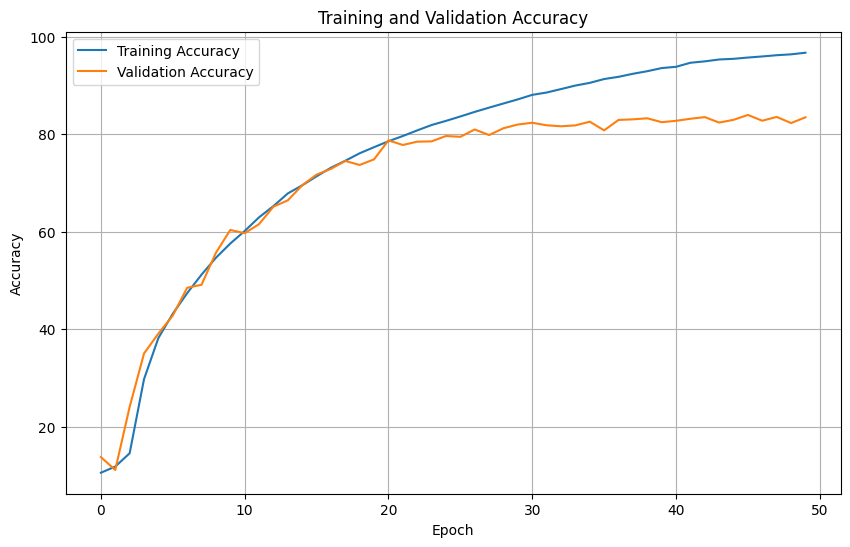

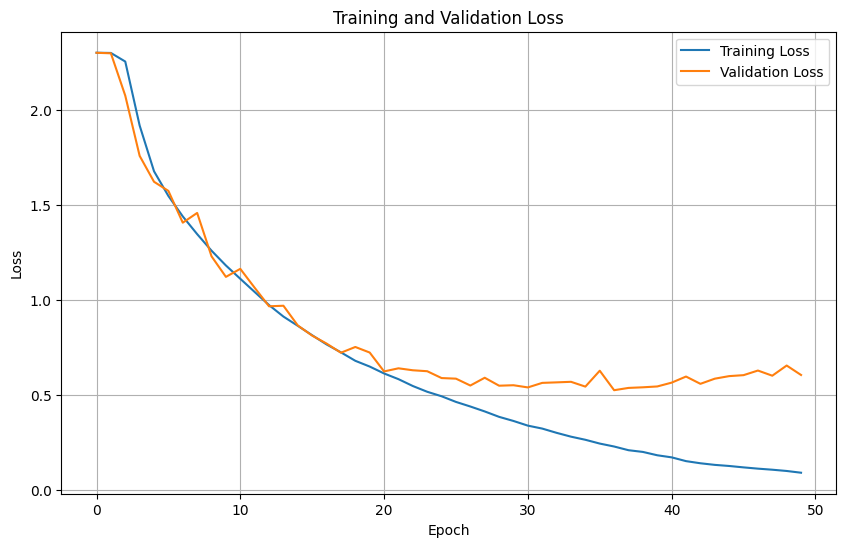

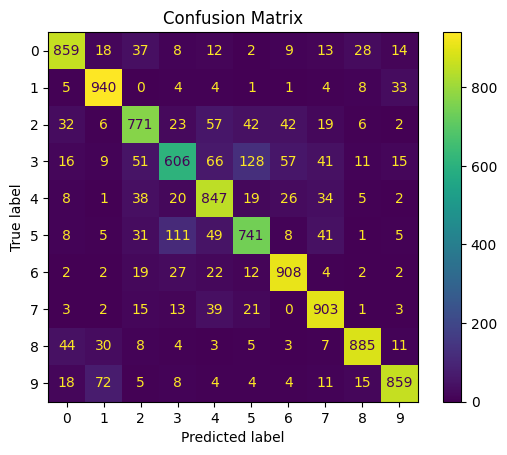

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(best_model_wts)
test_loss, test_acc = eval_step(model, test_loader, criterion, device)
print(f'AlexNet Test Accuracy: {test_acc:.2f}%')

# Plot metrics
plot_metrics(train_losses, train_accs, val_losses, val_accs)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, device)

### ResNet-18

In [ ]:
# Initialize ResNet-18
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 10)  # Modify for CIFAR-10
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc = eval_step(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print('-' * 60)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/30:
------------------------------------------------------------
Train Loss: 1.7021, Train Acc: 36.80%
Val Loss: 1.5220, Val Acc: 42.76%

Epoch 2/30:
------------------------------------------------------------
Train Loss: 1.3343, Train Acc: 51.29%
Val Loss: 1.3017, Val Acc: 52.40%

Epoch 3/30:
------------------------------------------------------------
Train Loss: 1.1520, Train Acc: 58.51%
Val Loss: 1.1417, Val Acc: 58.30%

Epoch 4/30:
------------------------------------------------------------
Train Loss: 1.0030, Train Acc: 64.17%
Val Loss: 1.1049, Val Acc: 61.20%

Epoch 5/30:
------------------------------------------------------------
Train Loss: 0.8877, Train Acc: 68.42%
Val Loss: 1.0351, Val Acc: 63.60%

Epoch 6/30:
------------------------------------------------------------
Train Loss: 0.7841, Train Acc: 72.51%
Val Loss: 1.0025, Val Acc: 65.12%

Epoch 7/30:
------------------------------------------------------------
Train Loss: 0.6962, Train Acc: 75.54%
Val Loss: 0.9

ResNet-18 Test Accuracy: 75.30%


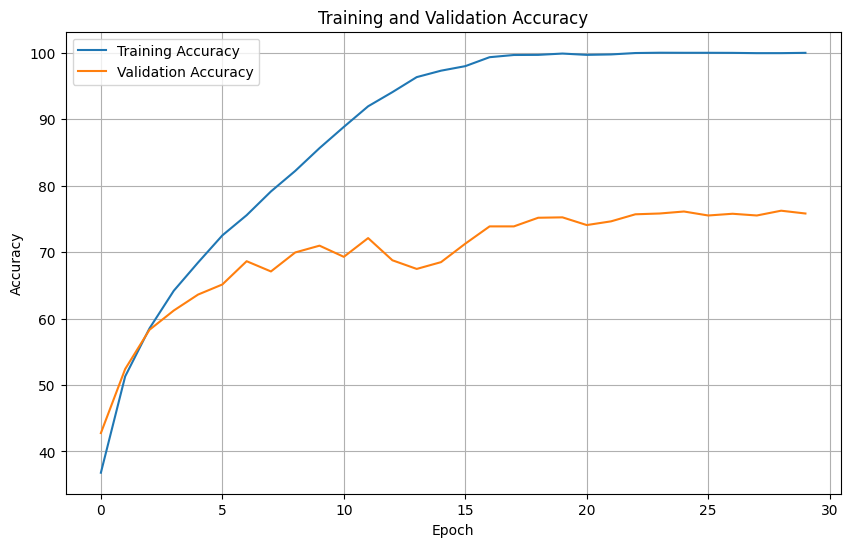

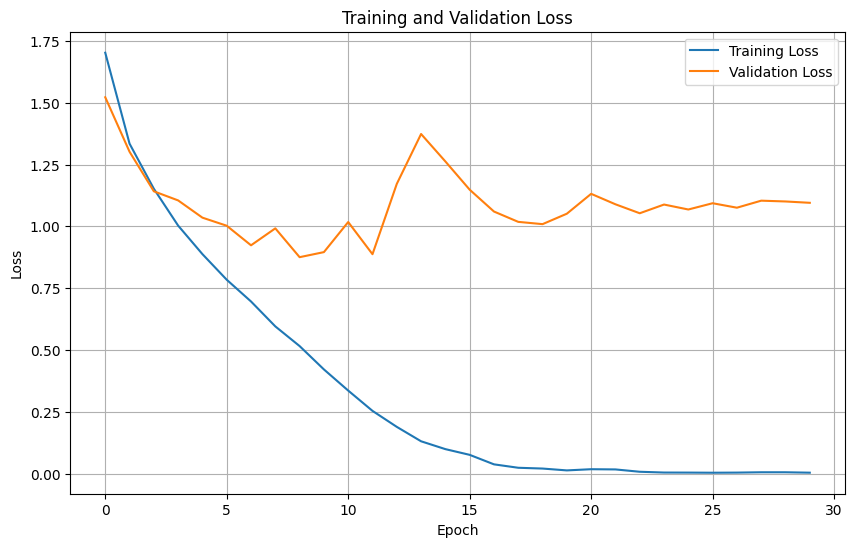

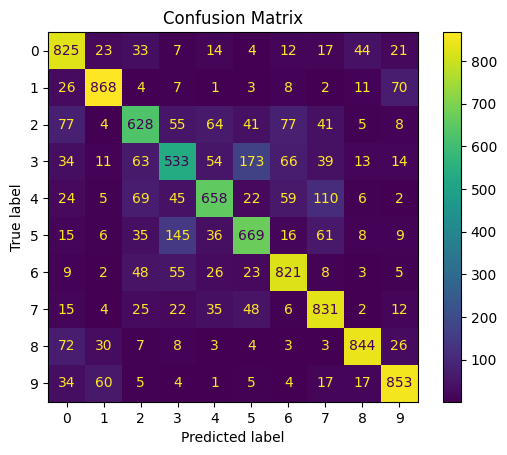

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(best_model_wts)
test_loss, test_acc = eval_step(model, test_loader, criterion, device)
print(f'ResNet-18 Test Accuracy: {test_acc:.2f}%')

# Plot metrics
plot_metrics(train_losses, train_accs, val_losses, val_accs)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, device)

### MobileNet (v2)

In [ ]:
# Initialize MobileNetV2
model = mobilenet_v2(pretrained=False)
model.classifier[-1] = nn.Linear(1280, 10)  # Modify for CIFAR-10
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
num_epochs = 30
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(num_epochs):
    # Training phase
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc = eval_step(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}/{num_epochs}:')01
    print('-' * 60)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/30:
------------------------------------------------------------
Train Loss: 1.8063, Train Acc: 30.62%
Val Loss: 1.5382, Val Acc: 42.36%

Epoch 2/30:
------------------------------------------------------------
Train Loss: 1.4397, Train Acc: 46.86%
Val Loss: 1.3532, Val Acc: 50.88%

Epoch 3/30:
------------------------------------------------------------
Train Loss: 1.2169, Train Acc: 56.02%
Val Loss: 1.1411, Val Acc: 59.20%

Epoch 4/30:
------------------------------------------------------------
Train Loss: 1.0551, Train Acc: 62.14%
Val Loss: 1.0226, Val Acc: 64.08%

Epoch 5/30:
------------------------------------------------------------
Train Loss: 0.9393, Train Acc: 66.65%
Val Loss: 0.9356, Val Acc: 66.54%

Epoch 6/30:
------------------------------------------------------------
Train Loss: 0.8473, Train Acc: 69.92%
Val Loss: 0.8586, Val Acc: 70.46%

Epoch 7/30:
------------------------------------------------------------
Train Loss: 0.7592, Train Acc: 73.34%
Val Loss: 0.8

MobileNetV2 Test Accuracy: 78.59%


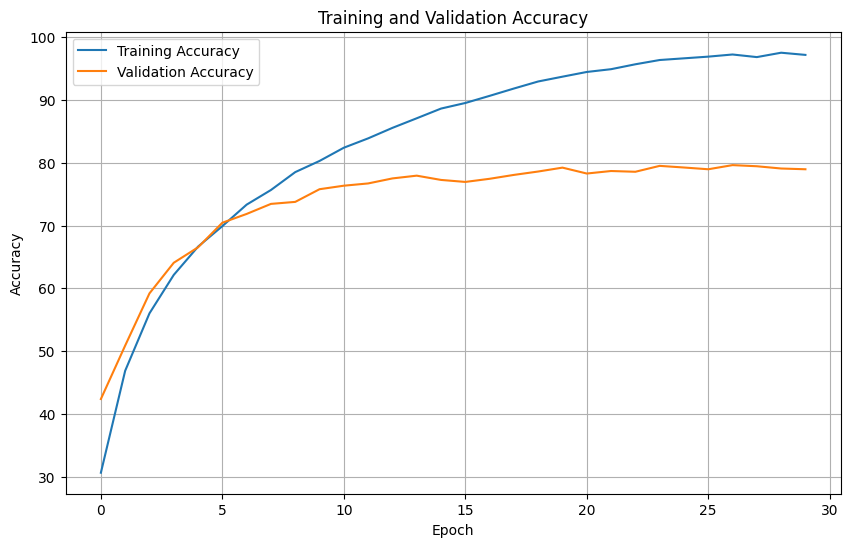

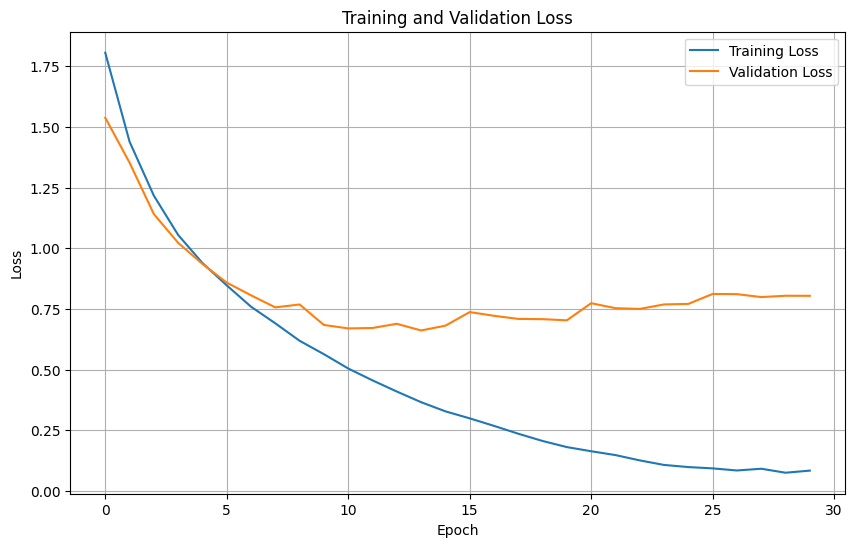

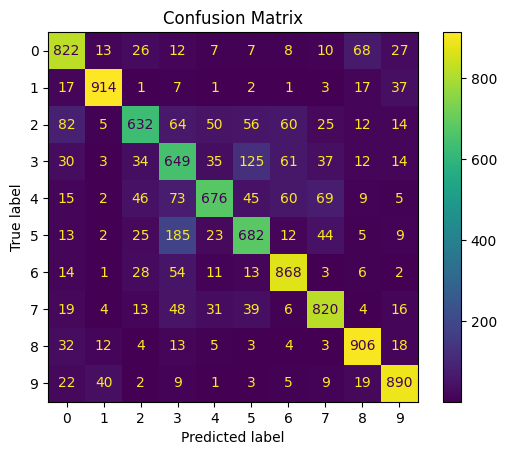

In [ ]:
# Load best model and evaluate on test set
model.load_state_dict(best_model_wts)
test_loss, test_acc = eval_step(model, test_loader, criterion, device)
print(f'MobileNetV2 Test Accuracy: {test_acc:.2f}%')

# Plot metrics
plot_metrics(train_losses, train_accs, val_losses, val_accs)

# Plot confusion matrix
plot_confusion_matrix(model, test_loader, device)